# Convert keras to tflite 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Github
%cd 'LacmusTflite'

Mounted at /content/drive/
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/LacmusTflite


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd

saved_model_dir = 'snapshots/B0/'
TFLITE_FILE_PATH = 'model.tflite'

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 224, 224, 3)
      yield [data.astype(np.uint8)]

In [ ]:
saved_model_dir = 'snapshots/B0_best/'

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('no_quant_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory

converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

In [ ]:
# Save the model.
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

In [ ]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.representative_dataset = representative_dataset
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
int_converter.inference_input_type = tf.int8  # or tf.uint8
int_converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = int_converter.convert()

In [ ]:
with open('int8_'+TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_quant_model)

## Prepare data 

In [ ]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['JPEGImages', 'ImageSets', 'Annotations']

In [ ]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        

In [ ]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [ ]:
it = iter(test_gen())

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

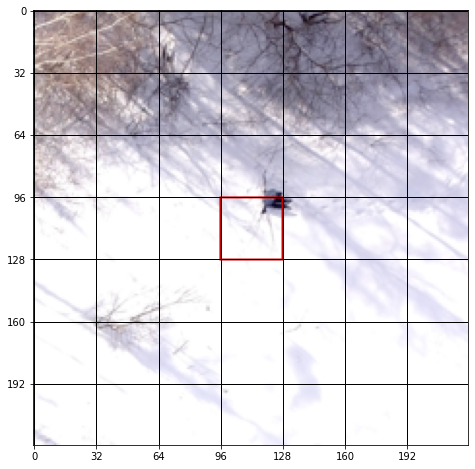

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.gca()
img_arr = sample[0]
y = sample[1].reshape((7,7))

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.where(y==1)).ravel()[::-1]


draw = ImageDraw.Draw(img)
if len(xy)>0:
  if len(xy)==1:
    bb = np.array([xy, xy+1]).ravel() * 32
    draw.rectangle(bb.tolist(), outline=(200,0,0))
  else: 
    for i in range(len(xy)):
      bb = np.array([xy, xy+1]).ravel() * 32
      draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

ax.grid(which='major', color='black', linestyle='-', linewidth=1)

plt.imshow(img)
plt.show()  

## Load Keras model

In [ ]:
x, y = sample

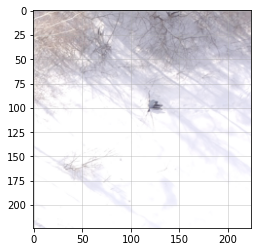

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

major_ticks = np.arange(0, 101, 20)
ax.grid(which='major', alpha=0.5)
plt.imshow(x)
#plt.show()  

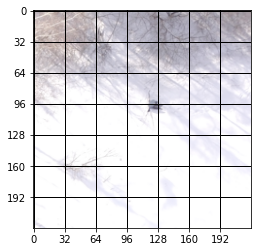

In [ ]:
plt.figure()
im = plt.imshow(x)

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

#

#

# Gridlines based on minor ticks
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
plt.show()

In [ ]:
model = tf.keras.models.load_model(saved_model_dir, compile=False )

In [ ]:
model.summary()

Model: "pe_det"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 dense (Dense)               multiple                  327936    
                                                                 
 p_re_lu (PReLU)             multiple                  12544     
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 p_re_lu_1 (PReLU)           multiple                  6272      
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 4,429,348
Trainable params: 379,777
Non-traina

In [ ]:
start = time.time()
pred=model(np.expand_dims(x, 0))
end = time.time()
#normal_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  10748.04973602295 ms


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  pred=model(np.expand_dims(x, 0))
end = time.time()
normal_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  24.19918465614319 ms


In [ ]:
import seaborn as sns

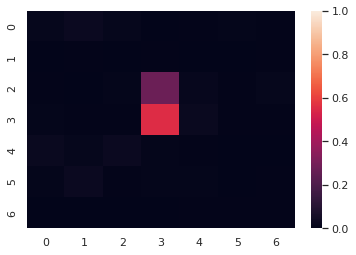

In [ ]:

sns.set()
ax = sns.heatmap(pred.numpy().reshape(7, 7), vmin=0, vmax=1)
plt.show()

In [ ]:
thresh=0.25

In [ ]:
precision = tf.keras.metrics.Precision(thresholds=thresh)
recall = tf.keras.metrics.Recall(thresholds=thresh)
auc = tf.keras.metrics.AUC()

In [ ]:
model.compile(metrics=[precision, recall, auc])

In [ ]:
start = time.time()
loss,prec,rec,auc =model.evaluate(test_dataset)
end = time.time()
print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
print(loss,prec,rec,auc)

23/23 [==============================] - 52s 2s/step - loss: 0.0000e+00 - precision: 0.6010 - recall: 0.9520 - auc: 0.9976
time per image:  288.2384909523858 ms
0.0 0.6010100841522217 0.9520000219345093 0.997639000415802


In [ ]:
normal_model_res=['B0',prec,rec,auc]

In [ ]:
pred=model.predict(test_dataset)

In [ ]:
x = np.concatenate([x for x, y in test_dataset], axis=0)

In [ ]:
x.shape

(180, 224, 224, 3)

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
y.shape

(180, 7, 7)

In [ ]:
l=list(np.round(np.arange(0,1.01,0.01),2))
thr=0.3
spec=[]
rec=[]
prec=[]
acc=[]
pcor=[]
for i in l:
  cm = confusion_matrix(y.reshape(-1), pred.reshape(-1)>i)
  spec.append(cm[0,0]/(cm[0,0]+cm[0,1]))
  rec.append(cm[1,1]/(cm[1,0]+cm[1,1]))
  prec.append(cm[1,1]/(cm[1,1]+cm[0,1]))
  acc.append((cm[1,1]+cm[0,0])/sum(cm.ravel()))
  pcor.append(cm[0,0]/(cm[0,0]+cm[1,0]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [ ]:
n_thr=(np.argmax(np.array(rec)<0.9)-1)/100
n_thr

0.29

In [ ]:
fscore=[]
f2score=[]
b=2
for i in range(len(prec)):
  fscore.append(2*prec[i]*rec[i]/(rec[i]+prec[i]))
  f2score.append((1+b**2)*prec[i]*rec[i]/(rec[i]+b**2 * prec[i]))

Text(0.5, 0, 'threshold')

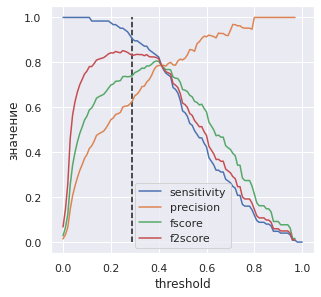

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(n_thr, 0,1,ls='--')
plt.legend( (
    #'specificity', 
    'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)> n_thr,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.992     0.995      8695
           1      0.628     0.904     0.741       125

    accuracy                          0.991      8820
   macro avg      0.813     0.948     0.868      8820
weighted avg      0.993     0.991     0.992      8820



In [ ]:
rec[35]

0.872

Text(0.5, 0, 'threshold')

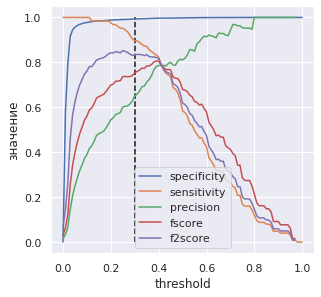

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(thr, 0,1,ls='--')
plt.legend( ('specificity', 'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

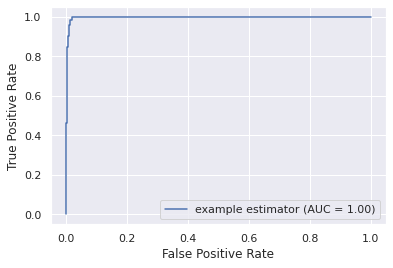

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y.reshape(-1), pred.reshape(-1))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

plt.show()

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)>0.3,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.993     0.996      8695
           1      0.651     0.896     0.754       125

    accuracy                          0.992      8820
   macro avg      0.825     0.945     0.875      8820
weighted avg      0.994     0.992     0.992      8820



In [ ]:
CM = confusion_matrix(y.reshape(-1), pred.reshape(-1)> 0.3)
CM

array([[8635,   60],
       [  13,  112]])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

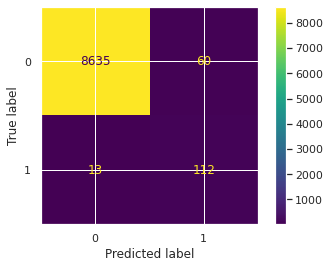

In [ ]:
ConfusionMatrixDisplay.from_predictions(y.reshape(-1), pred.reshape(-1)> 0.3, cmap='viridis',ax=None)
plt.show()

In [ ]:
f_thr=(np.nanargmax(np.array(f2score)))/100
f_thr

0.25

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)>f_thr,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.991     0.995      8695
           1      0.601     0.952     0.737       125

    accuracy                          0.990      8820
   macro avg      0.800     0.971     0.866      8820
weighted avg      0.994     0.990     0.991      8820



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y.reshape(-1), pred.reshape(-1)> f_thr)

print(cf_matrix)

[[8616   79]
 [   6  119]]


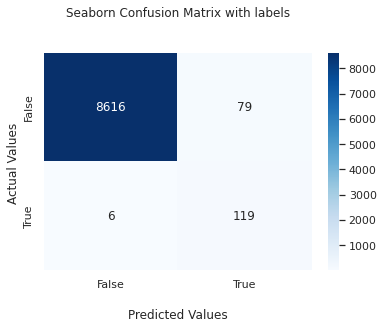

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
it = iter(test_gen())

In [ ]:
# import itertools    

# it=itertools.islice(it, 12,None)

In [ ]:
for i in range(30):
  sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

In [ ]:
y

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
xy = np.array(np.where(y==1)).ravel()[::-1]
xy

array([  1,   6,   4,   3,   1,   5,   4,   3,   2,   3,   1,   1,   1,
         0,   4,   2,   1,   6,   5,   4,   3,   1,   0,   2,   1,   4,
         3,   6,   5,   4,   2,   2,   6,   4,   6,   3,   5,   5,   3,
         1,   3,   1,   4,   6,   4,   2,   1,   5,   4,   2,   1,   2,
         5,   0,   5,   5,   4,   2,   1,   0,   4,   2,   5,   4,   0,
         2,   6,   4,   2,   1,   3,   6,   5,   4,   3,   4,   1,   6,
         3,   3,   5,   4,   4,   2,   1,   5,   4,   2,   1,   4,   1,
         4,   2,   0,   5,   5,   2,   4,   4,   2,   1,   0,   6,   5,
         4,   2,   5,   6,   2,   0,   6,   2,   2,   2,   2,   1,   0,
         5,   1,   2,   3,   1,   1,   2,   3,   5,   5,   6,   6,   6,
         6,   6,   6,   3,   0,   5,   2,   1,   2,   6,   6,   6,   5,
         5,   5,   5,   5,   2,   1,   1,   6,   2,   1,   1,   1,   4,
         3,   3,   2,   6,   3,   3,   1,   0,   1,   1,   6,   4,   3,
         6,   6,   6,   5,   5,   5,   5,   6,   1,   0,   5,   

[160  32 192  64]


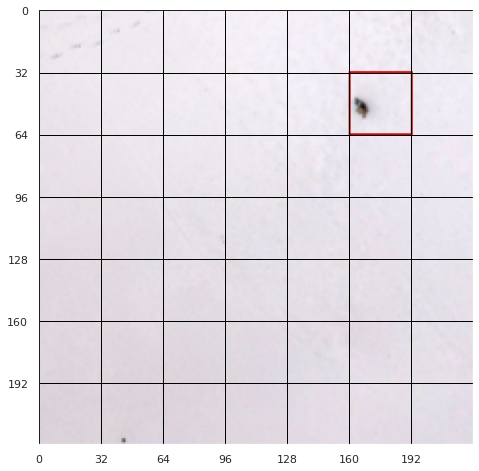

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.gca()
img_arr = sample[0]
y = sample[1].reshape((7,7))

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.argwhere(y==1))[:,::-1].ravel()


draw = ImageDraw.Draw(img)
if xy.size>0:
  if len(xy)==2:
    bb = np.array([xy, xy+1]).ravel() * 32
    print(bb)
    draw.rectangle(bb.tolist(), outline=(200,0,0))
  else: 
    for i in range(len(xy)//2):
      
      bb = np.array([xy[i*2:i*2+2], xy[i*2:i*2+2]+1]).ravel() * 32
      print(bb)
      draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

ax.grid(which='major', color='black', linestyle='-', linewidth=1)

plt.imshow(img)
plt.show()  

[128  32 160  64]
[160  32 192  64]


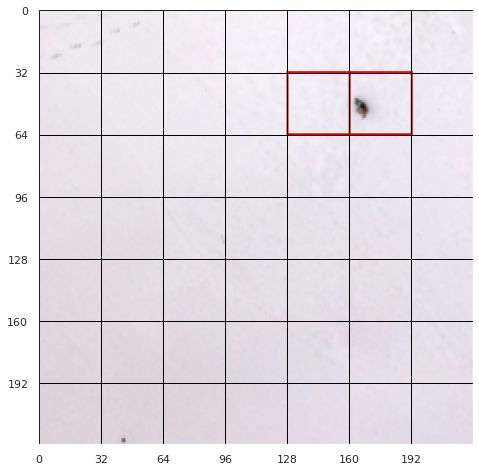

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.gca()
img_arr = sample[0]
pred=model(np.expand_dims(sample[0], 0))
pr=pred.numpy().reshape(7,7)

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.argwhere(pr>f_thr))[:,::-1].ravel()


draw = ImageDraw.Draw(img)
if xy.size>0:
  if len(xy)==2:
    bb = np.array([xy, xy+1]).ravel() * 32
    print(bb)
    draw.rectangle(bb.tolist(), outline=(200,0,0))
  else: 
    for i in range(len(xy)//2):
      
      bb = np.array([xy[i*2:i*2+2], xy[i*2:i*2+2]+1]).ravel() * 32
      print(bb)
      draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

ax.grid(which='major', color='black', linestyle='-', linewidth=1)

plt.imshow(img)
plt.show()  

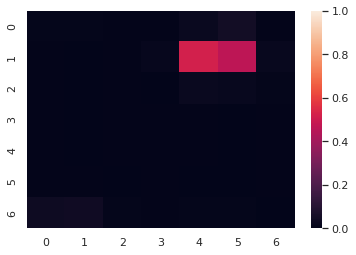

In [ ]:
sns.set()
ax = sns.heatmap(pred.numpy().reshape(7, 7), vmin=0, vmax=1)
plt.show()

In [ ]:
idx=test_idxs[11]
#43,24,11

In [ ]:
img_path = DATA_DIR + '/JPEGImages/' + f'{idx}.jpg'
img = load_img(img_path)
    
img_r = img.resize(size=(224, 224))

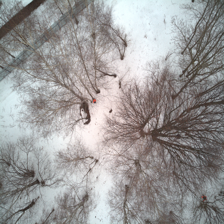

In [ ]:
img_r

In [ ]:
n = np.asarray(img_r)
n

array([[[107, 121, 119],
        [128, 142, 137],
        [138, 157, 157],
        ...,
        [107, 118, 116],
        [ 90,  96,  93],
        [ 79,  86,  83]],

       [[ 88,  96,  93],
        [107, 113, 111],
        [141, 155, 155],
        ...,
        [ 92, 102, 103],
        [ 82,  86,  84],
        [ 79,  83,  77]],

       [[ 70,  73,  69],
        [ 90,  95,  92],
        [138, 152, 149],
        ...,
        [ 77,  83,  80],
        [ 90,  97,  94],
        [ 73,  75,  70]],

       ...,

       [[101, 107, 105],
        [104, 111, 112],
        [104, 114, 114],
        ...,
        [ 98, 106, 107],
        [120, 129, 128],
        [ 89,  95,  97]],

       [[ 89,  95,  95],
        [ 94, 103, 101],
        [ 86,  88,  86],
        ...,
        [ 84,  90,  92],
        [100, 111, 112],
        [109, 119, 117]],

       [[107, 119, 116],
        [ 85,  92,  91],
        [ 76,  78,  74],
        ...,
        [ 99, 108, 109],
        [110, 126, 123],
        [104, 115, 114]]

[ 64  96  96 128]


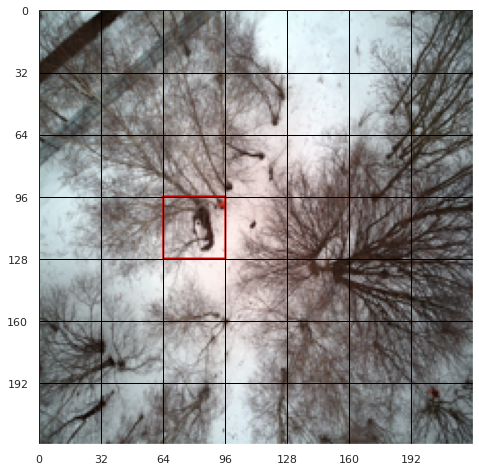

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.gca()
img_arr = n
pred=model(np.expand_dims(n, 0))
pr=pred.numpy().reshape(7,7)

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.argwhere(pr>f_thr))[:,::-1].ravel()


draw = ImageDraw.Draw(img)
if xy.size>0:
  if len(xy)==2:
    bb = np.array([xy, xy+1]).ravel() * 32
    print(bb)
    draw.rectangle(bb.tolist(), outline=(200,0,0))
  else: 
    for i in range(len(xy)//2):
      
      bb = np.array([xy[i*2:i*2+2], xy[i*2:i*2+2]+1]).ravel() * 32
      print(bb)
      draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

ax.grid(which='major', color='black', linestyle='-', linewidth=1)

plt.imshow(img)
plt.show()  

In [ ]:
pred

<tf.Tensor: shape=(1, 7, 7, 1), dtype=float32, numpy=
array([[[[1.3912242e-07],
         [1.5287584e-05],
         [2.4031192e-02],
         [5.0185136e-02],
         [7.4188285e-02],
         [6.0430624e-02],
         [1.6533813e-02]],

        [[1.3565150e-04],
         [8.4994786e-04],
         [8.8912547e-03],
         [8.0172770e-02],
         [5.9982602e-02],
         [4.5400325e-02],
         [1.4625542e-02]],

        [[7.5404616e-03],
         [4.2379270e-03],
         [1.1995332e-01],
         [1.2038766e-01],
         [7.4848741e-02],
         [2.8611615e-02],
         [2.1602940e-02]],

        [[2.9535709e-02],
         [4.5489345e-02],
         [3.6582196e-01],
         [1.4690337e-01],
         [6.5222725e-02],
         [1.7186105e-02],
         [2.4858136e-02]],

        [[9.7111449e-02],
         [1.3806028e-02],
         [9.9934079e-02],
         [9.4344109e-02],
         [8.1260964e-02],
         [1.6502896e-02],
         [2.9298030e-02]],

        [[1.2568015e-01],


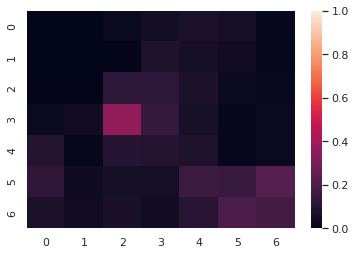

In [ ]:
sns.set()
ax = sns.heatmap(pred.numpy().reshape(7, 7), vmin=0, vmax=1)
plt.show()

## Tflite inference 

In [ ]:
x, y = sample

In [ ]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)

In [ ]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.get_input_details()[0]

{'dtype': numpy.uint8,
 'index': 0,
 'name': 'serving_default_input_1:0',
 'quantization': (0.0, 0),
 'quantization_parameters': {'quantized_dimension': 0,
  'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32)},
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'sparsity_parameters': {}}

In [ ]:
interpreter.get_output_details()

[{'dtype': numpy.float32,
  'index': 535,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 1, 1], dtype=int32),
  'shape_signature': array([-1, -1, -1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  224.10869598388672 ms
CPU times: user 191 ms, sys: 50.6 ms, total: 242 ms
Wall time: 224 ms


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  75.79265260696411 ms


In [ ]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  162.35190365049573 ms


In [ ]:

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter,test_images=test_gen,tresh=0.3):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  start = time.time()
  # Run predictions on every image in the "test" dataset.
  predictions = []
  test_labels=[]
  for test_image in test_gen():
    test_labels.append(test_image[1])
    test_image=test_image[0]
    
    test_image = np.expand_dims(test_image, axis=0).astype(np.uint8)
    interpreter.set_tensor(input_index, test_image)
    
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    pred = interpreter.get_tensor(output_index)
    predictions.append(pred)
  end = time.time()
  print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
  # Compare prediction results with ground truth labels to calculate accuracy.

  #print(np.array(predictions).reshape((-1)).shape,np.array(test_labels).shape)
  predictions=(np.array(predictions).reshape(-1))
  test_labels=(np.array(test_labels).reshape(-1))
  print (len(predictions))
  tn, fp, fn, tp = confusion_matrix(test_labels,predictions>=tresh).ravel()
  print(tn,fp,fn,tp)
  
  accuracy = (tp+tn)/(fp+fn+tp+tn)
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  fpr, tpr, thresholds =metrics.roc_curve(test_labels, predictions)
  AUC=metrics.auc(fpr, tpr)
  return accuracy,precision,recall,AUC

In [ ]:
%%time
print(evaluate_model(interpreter))

time per image:  164.3419822057088 ms
8820
8633 62 12 113
(0.991609977324263, 0.6457142857142857, 0.904, 0.9976455434157562)
CPU times: user 46.4 s, sys: 1.15 s, total: 47.5 s
Wall time: 44.8 s


In [ ]:
accuracy,precision,recall,AUC=evaluate_model(interpreter,tresh=0.25)

time per image:  161.41495439741345 ms
8820
8617 78 6 119


In [ ]:
quant_res= ['Quant float16',precision,recall,AUC]

In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (8, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (8, 7,7))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'],next(iter(test_dataset))[0])
# Run inference
interpreter.invoke()
# Get prediction results
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/8*(10**3),'ms')

time per image:  214.4661247730255 ms
CPU times: user 1.73 s, sys: 86.5 ms, total: 1.82 s
Wall time: 1.72 s


In [ ]:
normal_time

'24.19918465614319ms'

In [ ]:
quant_time

'224.10869598388672ms'

##Testing int8 quantization

In [ ]:
int_interpreter = tf.lite.Interpreter('int8_'+TFLITE_FILE_PATH)

In [ ]:
int_interpreter.allocate_tensors()

# Get input and output tensors.
input_details = int_interpreter.get_input_details()
output_details = int_interpreter.get_output_details()

In [ ]:
%%time
start = time.time()
int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
int_interpreter.invoke()
output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
int_quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  1375.5016326904297 ms
CPU times: user 1.37 s, sys: 11.3 ms, total: 1.38 s
Wall time: 1.38 s


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  1330.5635294914246 ms


In [ ]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  1406.0163723097908 ms


In [ ]:
print(evaluate_model(int_interpreter))

time per image:  1421.6101911332873 ms
8820
8695 0 125 0
(0.985827664399093, nan, 0.0, 0.5069557216791261)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
accuracy,precision,recall,AUC=evaluate_model(int_interpreter)
int_quant_res= ['Quant int8',precision,recall,AUC]

time per image:  1416.4646797709995 ms
8820
8695 0 125 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
normal_model_res

['B0', 0.6010100841522217, 0.9520000219345093, 0.997639000415802]

In [ ]:
normal_model_res.append(normal_time)
quant_res.append(quant_time)
int_quant_res.append(int_quant_time)

In [ ]:
cols=['Model', 'Precision','Recall','auc','inference time']
l=len(cols)
lst = [normal_model_res[:l],quant_res[:l],int_quant_res[:l]]
    
df = pd.DataFrame(lst, columns =cols)[['Model', 'Precision','Recall','inference time']]
df

,Model,Precision,Recall,inference time
0,B0,0.601010,0.952,24.19918465614319ms
1,Quant float16,0.604061,0.952,224.10869598388672ms
2,Quant int8,NaN,0.000,1375.5016326904297ms
